# Model
## Wav2Vec2 2Class

In [1]:
# Import Required Libraries
import os, json, time, re, random, numpy as np
from pathlib import Path
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

try:
    import torchaudio
    HAVE_TA = True
except Exception:
    HAVE_TA = False
    print("[WARN] torchaudio not found, augmentation disabled.")

import pyedflib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_auc_score,
    log_loss, average_precision_score
)

from transformers import (
    Wav2Vec2Processor, Wav2Vec2ForSequenceClassification,
    get_linear_schedule_with_warmup
)

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Device and Reproducibility Setup
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"CUDA Version: {torch.version.cuda}")
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda
GPU: NVIDIA GeForce RTX 4060
CUDA Version: 12.1


In [3]:
# Binary Classification Configuration - FIXED
CSV_PATH = r"C:\V89\Snore_Apnea_Analyze\EDF_RML\data_csv\respiratory_plus_normal.csv"
EDF_ROOT = r"C:\V89\data2"

# Model Configuration
MODEL_NAME = "facebook/wav2vec2-base"
MODEL_TAG = "wav2vec2-binary-apnea-vs-normal-v2-fixed"

# Training Parameters - OPTIMIZED
SAMPLE_RATE = 16000
MAX_SECONDS = 8
BATCH_SIZE = 4  # ลด batch size
EPOCHS = 5      # ลดเป็น 5 epochs
LR = 5e-6      # ลด learning rate
WARMUP_RATIO = 0.05  # ลด warmup

# Training Options
FREEZE_BASE = False
AUGMENT = True
USE_CLASS_WEIGHTS = True

print("Configuration loaded:")
print(f"  Model: {MODEL_NAME}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LR}")
print(f"  Max Audio Length: {MAX_SECONDS}s")
print(f"  Use Class Weights: {USE_CLASS_WEIGHTS}")

Configuration loaded:
  Model: facebook/wav2vec2-base
  Batch Size: 4
  Epochs: 5
  Learning Rate: 5e-06
  Max Audio Length: 8s
  Use Class Weights: True


In [4]:
# Create Binary Dataset (Apnea vs Normal)
print("Loading original dataset...")
df_original = pd.read_csv(CSV_PATH)
print("Original class distribution:")
print(df_original['type'].value_counts())

def create_binary_classes(df):
    """Convert multi-class to binary: Apnea vs Normal"""
    df_new = df.copy()
    
    # Combine all respiratory events into "Apnea"
    apnea_types = ['ObstructiveApnea', 'Hypopnea', 'MixedApnea', 'CentralApnea']
    df_new.loc[df_new['type'].isin(apnea_types), 'type'] = 'Apnea'
    # Normal remains "Normal"
    
    return df_new

# Create binary dataset
df_binary = create_binary_classes(df_original)
print("\nBinary class distribution:")
print(df_binary['type'].value_counts())

# Save binary dataset
binary_csv_path = r"C:\V89\Snore_Apnea_Analyze\EDF_RML\data_csv\apnea_vs_normal.csv"
df_binary.to_csv(binary_csv_path, index=False)
print(f"\nBinary dataset saved to: {binary_csv_path}")

# Update CSV_PATH to use binary dataset
CSV_PATH = binary_csv_path

Loading original dataset...
Original class distribution:
type
Normal              912
ObstructiveApnea    649
Hypopnea            398
MixedApnea           72
CentralApnea         38
Name: count, dtype: int64

Binary class distribution:
type
Apnea     1157
Normal     912
Name: count, dtype: int64

Binary dataset saved to: C:\V89\Snore_Apnea_Analyze\EDF_RML\data_csv\apnea_vs_normal.csv


In [5]:
# Sleep Apnea Dataset Class
class SleepApneaDataset(Dataset):
    """
    Dataset for loading EDF audio segments with respiratory event labels.
    Handles EDF file resolution and audio channel selection automatically.
    """
    def __init__(self, df: pd.DataFrame, edf_root: str, sample_rate: int = 16000,
                 prefer_audio_channels=("sound","snore","tracheal","microphone","audio","throat")):
        self.sample_rate = sample_rate
        self.edf_root = Path(edf_root)
        self.prefer_audio_channels = tuple(s.lower() for s in prefer_audio_channels)

        df = df.copy()
        df["pid_str"] = df["patient_id"].astype(str)
        df["pid_unpad"] = df["pid_str"].str.lstrip("0")
        df["pid_pad8"] = df["pid_unpad"].str.zfill(8)
        df["seg3"] = df["segment_index"].astype(int).map(lambda x: f"{x:03d}")

        def resolve_edf_path(row):
            """Find matching EDF file for this row"""
            pid_unpad, pid_pad8, seg3 = row["pid_unpad"], row["pid_pad8"], row["seg3"]
            patterns = [
                f"*{pid_pad8}*{seg3}*.edf",
                f"*{pid_unpad}*{seg3}*.edf",
                f"*{pid_pad8}*.edf",
                f"*{pid_unpad}*.edf",
            ]
            for pat in patterns:
                hits = list(self.edf_root.rglob(pat))
                if len(hits) == 1:
                    return hits[0]
                if len(hits) > 1:
                    # Rank by segment match and audio-related keywords
                    ranked = sorted(hits, key=lambda p: (
                        0 if re.search(rf"{seg3}\b", p.stem) else 1,
                        0 if re.search(r"(snore|sound|trach|mic|psg|audio|throat)", p.stem.lower()) else 1,
                        len(p.as_posix())
                    ))
                    return ranked[0]
            return None

        # Resolve EDF paths and filter out missing files
        df["edf_path"] = df.apply(resolve_edf_path, axis=1)
        missing = df["edf_path"].isna().sum()
        if missing > 0:
            print(f"[WARNING] Skipping {missing} rows without matching EDF files")
        df = df.dropna(subset=["edf_path"]).reset_index(drop=True)

        self.df = df
        self.labels = sorted(self.df['type'].unique().tolist())
        self.label_encoder = LabelEncoder().fit(self.labels)
        
        print(f"Dataset initialized:")
        print(f"  Total samples: {len(self.df)}")
        print(f"  Classes: {self.labels}")

    def __len__(self):
        return len(self.df)

    def _pick_audio_channel(self, edf_reader):
        """Select the best audio channel from EDF file"""
        labels = [s.lower() for s in edf_reader.getSignalLabels()]
        for i, name in enumerate(labels):
            if any(key in name for key in self.prefer_audio_channels):
                return i
        return 0  # fallback to first channel

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        edf_path = Path(row["edf_path"])
        start_sec = float(row['segment_local_start_sec'])
        duration_sec = float(row['duration_sec'])
        label = self.label_encoder.transform([row['type']])[0]

        # Load audio segment from EDF
        edf_reader = pyedflib.EdfReader(str(edf_path))
        ch_idx = self._pick_audio_channel(edf_reader)
        signal = edf_reader.readSignal(ch_idx)
        fs = edf_reader.getSampleFrequency(ch_idx)
        edf_reader.close()

        # Extract segment
        start_sample = max(0, int(start_sec * fs))
        end_sample = min(int((start_sec + duration_sec) * fs), len(signal))
        audio = signal[start_sample:end_sample]

        # Convert to tensor and resample if needed
        x = torch.tensor(audio, dtype=torch.float32)
        if fs != self.sample_rate:
            if not HAVE_TA:
                raise RuntimeError("torchaudio required for resampling")
            x = torchaudio.transforms.Resample(fs, self.sample_rate)(x)

        return {"audio": x, "label": int(label)}

In [6]:
# Load Dataset and Create Splits
print("Loading binary dataset...")
df_binary = pd.read_csv(CSV_PATH)
dataset_binary = SleepApneaDataset(df_binary, edf_root=EDF_ROOT, sample_rate=SAMPLE_RATE)

label_names_binary = list(dataset_binary.label_encoder.classes_)
n_classes_binary = len(label_names_binary)

print(f"Binary dataset loaded successfully!")
print(f"Classes: {label_names_binary}")
print(f"Number of classes: {n_classes_binary}")

# Create Train/Val/Test Splits
SPLIT_FILE_BINARY = Path("./splits/binary_data_split.json")

if SPLIT_FILE_BINARY.exists():
    # Load existing splits
    with open(SPLIT_FILE_BINARY, "r") as f:
        idx_binary = json.load(f)
    train_idx_binary = idx_binary["train"]
    val_idx_binary = idx_binary["val"] 
    test_idx_binary = idx_binary["test"]
    print("Loaded existing data splits")
else:
    # Create new splits
    g = torch.Generator().manual_seed(SEED)
    N_binary = len(dataset_binary)
    perm_binary = torch.randperm(N_binary, generator=g).tolist()
    
    train_ratio, val_ratio = 0.8, 0.1
    n_train_binary = int(train_ratio * N_binary)
    n_val_binary = int(val_ratio * N_binary)
    
    train_idx_binary = perm_binary[:n_train_binary]
    val_idx_binary = perm_binary[n_train_binary:n_train_binary + n_val_binary]
    test_idx_binary = perm_binary[n_train_binary + n_val_binary:]
    
    # Save splits
    SPLIT_FILE_BINARY.parent.mkdir(parents=True, exist_ok=True)
    with open(SPLIT_FILE_BINARY, "w") as f:
        json.dump({
            "train": train_idx_binary, 
            "val": val_idx_binary, 
            "test": test_idx_binary
        }, f, indent=2)
    print("Created and saved new data splits")

# Create subset datasets
train_ds_binary = Subset(dataset_binary, train_idx_binary)
val_ds_binary = Subset(dataset_binary, val_idx_binary)
test_ds_binary = Subset(dataset_binary, test_idx_binary)

print(f"\nDataset splits:")
print(f"  Train: {len(train_ds_binary)} samples")
print(f"  Val:   {len(val_ds_binary)} samples")
print(f"  Test:  {len(test_ds_binary)} samples")

# Quick class distribution check
def check_distribution(dataset, indices, name):
    labels = [dataset.label_encoder.transform([dataset.df.iloc[i]['type']])[0] for i in indices]
    from collections import Counter
    cnt = Counter(labels)
    cnt_named = {dataset.label_encoder.classes_[k]: v for k, v in cnt.items()}
    print(f"{name}: {cnt_named}")

print("\nClass distributions:")
check_distribution(dataset_binary, train_idx_binary, "Train")
check_distribution(dataset_binary, val_idx_binary, "Val")
check_distribution(dataset_binary, test_idx_binary, "Test")

Loading binary dataset...
[WARNING] Skipping 245 rows without matching EDF files
Dataset initialized:
  Total samples: 1824
  Classes: ['Apnea', 'Normal']
Binary dataset loaded successfully!
Classes: [np.str_('Apnea'), np.str_('Normal')]
Number of classes: 2
Loaded existing data splits

Dataset splits:
  Train: 1459 samples
  Val:   182 samples
  Test:  183 samples

Class distributions:
Train: {np.str_('Apnea'): 729, np.str_('Normal'): 730}
Val: {np.str_('Normal'): 88, np.str_('Apnea'): 94}
Test: {np.str_('Apnea'): 89, np.str_('Normal'): 94}
[WARNING] Skipping 245 rows without matching EDF files
Dataset initialized:
  Total samples: 1824
  Classes: ['Apnea', 'Normal']
Binary dataset loaded successfully!
Classes: [np.str_('Apnea'), np.str_('Normal')]
Number of classes: 2
Loaded existing data splits

Dataset splits:
  Train: 1459 samples
  Val:   182 samples
  Test:  183 samples

Class distributions:
Train: {np.str_('Apnea'): 729, np.str_('Normal'): 730}
Val: {np.str_('Normal'): 88, np.s

In [7]:
# Wav2Vec2 Data Collator
class Wav2Vec2Collator:
    """Prepare raw waveforms for Wav2Vec2 (padding + attention mask + optional augmentation)"""
    def __init__(self, processor, sr=16000, max_seconds=8, augment=False):
        self.processor = processor
        self.sr = sr
        self.max_len = int(max_seconds * sr)
        self.augment = augment and HAVE_TA

    def _augment(self, x: torch.Tensor) -> torch.Tensor:
        """Apply light audio augmentations"""
        if not self.augment:
            return x
        
        # Gaussian noise (50% chance)
        if random.random() < 0.5:
            noise_std = 0.005 * (x.abs().mean().item() + 1e-6)
            x = x + torch.randn_like(x) * noise_std
        
        # Random gain (30% chance)
        if random.random() < 0.3:
            gain_db = random.uniform(-3.0, 3.0)
            x = x * (10.0 ** (gain_db / 20.0))
        
        return x

    def __call__(self, batch):
        waves, labels = [], []
        
        for sample in batch:
            w = sample["audio"]
            if isinstance(w, np.ndarray):
                w = torch.from_numpy(w)
            w = w.float().view(-1)

            # Crop long clips randomly
            if len(w) > self.max_len:
                start = random.randint(0, len(w) - self.max_len)
                w = w[start:start + self.max_len]

            # Peak normalize
            peak = w.abs().max()
            if peak > 0:
                w = w / peak

            # Apply augmentation
            w = self._augment(w)

            waves.append(w.numpy())
            labels.append(int(sample["label"]))

        # Process with Wav2Vec2 processor
        inputs = self.processor(
            waves,
            sampling_rate=self.sr,
            return_tensors="pt",
            padding=True,
            truncation=False
        )
        inputs["labels"] = torch.tensor(labels, dtype=torch.long)
        return inputs

# Setup Model and Processor
print("Setting up Wav2Vec2 model...")
processor_binary = Wav2Vec2Processor.from_pretrained(MODEL_NAME)

model_binary = Wav2Vec2ForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=n_classes_binary,
    ignore_mismatched_sizes=True,
    use_safetensors=True
)

# Configure label mappings
model_binary.config.id2label = {i: name for i, name in enumerate(label_names_binary)}
model_binary.config.label2id = {name: i for i, name in enumerate(label_names_binary)}

model_binary.to(device)

# Count parameters
trainable_params = sum(p.numel() for p in model_binary.parameters() if p.requires_grad)
print(f"Model loaded successfully!")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model classes: {label_names_binary}")

# Create Data Loaders
collate_fn_binary = Wav2Vec2Collator(processor_binary, sr=SAMPLE_RATE, max_seconds=MAX_SECONDS, augment=AUGMENT)

NUM_WORKERS = 0  # Keep 0 for Windows compatibility
PIN_MEMORY = (device.type == "cuda")

train_loader_binary = DataLoader(
    train_ds_binary, batch_size=BATCH_SIZE, shuffle=True,
    collate_fn=collate_fn_binary, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)
val_loader_binary = DataLoader(
    val_ds_binary, batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=collate_fn_binary, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)
test_loader_binary = DataLoader(
    test_ds_binary, batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=collate_fn_binary, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)

print(f"\nData loaders created:")
print(f"  Train batches: {len(train_loader_binary)}")
print(f"  Val batches: {len(val_loader_binary)}")
print(f"  Test batches: {len(test_loader_binary)}")

Setting up Wav2Vec2 model...


c:\V89\.venv\Lib\site-packages\transformers\configuration_utils.py:334: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream tas

Model loaded successfully!
Trainable parameters: 94,569,090
Model classes: [np.str_('Apnea'), np.str_('Normal')]

Data loaders created:
  Train batches: 365
  Val batches: 46
  Test batches: 46


In [8]:
# Evaluation Functions
def evaluate_model(model, loader, label_encoder, device, return_arrays=False):
    """Comprehensive model evaluation with metrics calculation"""
    model.eval()
    y_true, y_pred, y_proba_chunks = [], [], []
    
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(
                input_values=batch["input_values"],
                attention_mask=batch.get("attention_mask", None)
            ).logits
            
            proba = torch.softmax(logits, dim=-1).cpu().numpy()
            y_proba_chunks.append(proba)
            y_pred.extend(np.argmax(proba, axis=1))
            y_true.extend(batch["labels"].cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.vstack(y_proba_chunks) if len(y_proba_chunks) > 0 else np.zeros((0, len(label_encoder.classes_)))

    class_names = list(label_encoder.classes_)
    n_classes = len(class_names)
    
    # Handle case where not all classes appear in predictions
    unique_labels = np.unique(np.concatenate([y_true, y_pred]))
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred) if len(y_true) else np.nan
    f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0) if len(y_true) else np.nan
    f1_weighted = f1_score(y_true, y_pred, average="weighted", zero_division=0) if len(y_true) else np.nan
    prec_macro, rec_macro, _, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0) if len(y_true) else (np.nan, np.nan, None, None)

    # Balanced accuracy
    cm_float = cm.astype(float) if cm.size else np.zeros((len(unique_labels), len(unique_labels)), float)
    row_sums = cm_float.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    bal_acc = (cm_float / row_sums).diagonal().mean() if cm.size else np.nan

    # ROC AUC and PR AUC
    try:
        roc_auc_macro = roc_auc_score(y_true, y_proba, multi_class="ovr", average="macro")
    except Exception:
        roc_auc_macro = np.nan
    
    try:
        pr_auc_macro = average_precision_score(np.eye(n_classes)[y_true], y_proba, average="macro")
    except Exception:
        pr_auc_macro = np.nan
    
    try:
        ll = log_loss(y_true, y_proba, labels=list(range(n_classes)))
    except Exception:
        ll = np.nan

    # Classification report
    report_dict = classification_report(
        y_true, y_pred, 
        labels=unique_labels,
        target_names=[class_names[i] for i in unique_labels],
        output_dict=True, zero_division=0
    ) if len(y_true) else {}

    metrics = {
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "roc_auc_macro": roc_auc_macro,
        "pr_auc_macro": pr_auc_macro,
        "log_loss": ll,
        "support": int(len(y_true))
    }
    
    out = (metrics, report_dict, cm, class_names)
    if return_arrays:
        return out + (y_true, y_pred, y_proba)
    return out

def save_confusion_matrix(cm, class_names, save_path, normalize=True, title=None):
    """Save confusion matrix visualization"""
    cm_plot = cm.astype(float)
    if normalize and cm_plot.size:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        cm_plot = cm_plot / row_sums

    plt.figure(figsize=(8, 6))
    plt.imshow(cm_plot, interpolation='nearest', cmap='Blues')
    plt.title(title or "Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)

    fmt = ".3f" if normalize else "d"
    thresh = cm_plot.max() / 2. if cm_plot.size else 0.5
    
    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            val = cm_plot[i, j] if normalize else int(cm[i, j])
            color = "white" if (cm_plot[i, j] if cm_plot.size else 0) > thresh else "black"
            plt.text(j, i, format(val, fmt), ha="center", va="center", color=color)
    
    plt.tight_layout()
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.close()

def save_classification_report(report_dict, save_csv_path):
    """Save classification report to CSV"""
    if not report_dict:
        return None
    df = pd.DataFrame(report_dict).T
    Path(save_csv_path).parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(save_csv_path, index=True)
    return df

def append_metrics_row(results_csv, model_name, split_name, metrics, extras=None):
    """Append metrics to results CSV file"""
    row = {
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model": model_name,
        "split": split_name,
        **metrics
    }
    if extras:
        row.update(extras)
    
    if os.path.exists(results_csv):
        df = pd.read_csv(results_csv)
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    else:
        df = pd.DataFrame([row])
    
    Path(results_csv).parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(results_csv, index=False)
    return df.tail(1)

print("Evaluation functions defined successfully!")

Evaluation functions defined successfully!


In [9]:
# Training Setup - FIXED VERSION
OUT_DIR_BINARY = Path(f"./eval_out/{MODEL_TAG}")
OUT_DIR_BINARY.mkdir(parents=True, exist_ok=True)

# Training components
total_steps_binary = len(train_loader_binary) * EPOCHS
warmup_steps_binary = int(total_steps_binary * WARMUP_RATIO)

# ===== FIX 1: ใช้ AdamW với weight decay =====
optimizer_binary = torch.optim.AdamW(
    model_binary.parameters(), 
    lr=LR, 
    weight_decay=0.01,
    betas=(0.9, 0.999),
    eps=1e-8
)
scheduler_binary = get_linear_schedule_with_warmup(optimizer_binary, warmup_steps_binary, total_steps_binary)

# AMP Setup
use_amp_binary = (device.type == "cuda")
scaler_binary = torch.cuda.amp.GradScaler(enabled=use_amp_binary)

# ===== FIX 2: ปรับ Class Weights =====
if USE_CLASS_WEIGHTS:
    all_y_binary = dataset_binary.label_encoder.transform(dataset_binary.df['type'])
    from sklearn.utils.class_weight import compute_class_weight
    classes_binary = np.arange(n_classes_binary)
    weights_binary = compute_class_weight(class_weight='balanced', classes=classes_binary, y=all_y_binary)
    
    # ลดความรุนแรงของ class weights
    weights_binary = np.sqrt(weights_binary)
    
    class_weights_binary = torch.tensor(weights_binary, dtype=torch.float32, device=device)
    
    # ===== FIX 3: เพิ่ม Label Smoothing =====
    ce_loss_binary = nn.CrossEntropyLoss(weight=class_weights_binary, label_smoothing=0.1)
    print(f"Using smoothed class weights: {dict(zip(label_names_binary, weights_binary))}")
    print(f"Label smoothing: 0.1")
else:
    ce_loss_binary = nn.CrossEntropyLoss(label_smoothing=0.1)

print("Training setup complete!")
print(f"  Total training steps: {total_steps_binary}")
print(f"  Warmup steps: {warmup_steps_binary}")
print(f"  Using AMP: {use_amp_binary}")
print(f"  Output directory: {OUT_DIR_BINARY}")

# Quick evaluation function for training
def run_eval_and_log_binary(split_name, loader):
    """Evaluate model and log results"""
    metrics, report, cm, class_names = evaluate_model(model_binary, loader, dataset_binary.label_encoder, device)
    
    # Format metrics nicely
    formatted_metrics = {k: f"{v:.4f}" if isinstance(v, float) else v for k, v in metrics.items()}
    print(f"{split_name.upper()}: {formatted_metrics}")
    
    # Save visualizations
    save_confusion_matrix(cm, class_names, OUT_DIR_BINARY / f"cm_{split_name}.png", 
                         normalize=True, title=f"Binary {split_name.title()} Confusion Matrix")
    save_classification_report(report, OUT_DIR_BINARY / f"cls_report_{split_name}.csv")
    
    # Log to scoreboard
    dataset_size = len(loader.dataset) if hasattr(loader, "dataset") else len(loader.dataset.dataset) if hasattr(loader.dataset, "dataset") else None
    append_metrics_row("./eval_out/binary_scoreboard.csv", MODEL_TAG, split_name, metrics, 
                      extras={f"n_{split_name}": dataset_size})
    return metrics

Using smoothed class weights: {np.str_('Apnea'): np.float64(1.0), np.str_('Normal'): np.float64(1.0)}
Label smoothing: 0.1
Training setup complete!
  Total training steps: 1825
  Warmup steps: 91
  Using AMP: True
  Output directory: eval_out\wav2vec2-binary-apnea-vs-normal-v2-fixed


C:\Users\Abcde\AppData\Local\Temp\ipykernel_24968\2833564887.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_binary = torch.cuda.amp.GradScaler(enabled=use_amp_binary)


In [10]:
# Final Evaluation and Model Saving
print("\nFinal Evaluation on TEST Split:")
final_metrics = run_eval_and_log_binary("test", test_loader_binary)

# Get raw predictions for analysis
print("Extracting predictions for analysis...")
_, _, _, _, y_true_test_binary, y_pred_test_binary, y_proba_test_binary = evaluate_model(
    model_binary, test_loader_binary, dataset_binary.label_encoder, device, return_arrays=True
)

# Save prediction arrays
np.save(OUT_DIR_BINARY / "y_true_test.npy", y_true_test_binary)
np.save(OUT_DIR_BINARY / "y_pred_test.npy", y_pred_test_binary) 
np.save(OUT_DIR_BINARY / "y_proba_test.npy", y_proba_test_binary)

# Save metadata
with open(OUT_DIR_BINARY / "class_names.json", "w") as f:
    json.dump(label_names_binary, f, ensure_ascii=False, indent=2)

# Save training configuration
with open(OUT_DIR_BINARY / "training_config.json", "w") as f:
    config = {
        "model_name": MODEL_NAME,
        "model_tag": MODEL_TAG,
        "epochs_configured": EPOCHS,  # Use configured epochs instead of actual trained
        "batch_size": BATCH_SIZE,
        "learning_rate": LR,
        "sample_rate": SAMPLE_RATE,
        "max_seconds": MAX_SECONDS,
        "use_class_weights": USE_CLASS_WEIGHTS,
        "augment": AUGMENT,
        "best_val_f1": best_val_f1 if 'best_val_f1' in globals() else 0.0,
        "final_test_metrics": final_metrics
    }
    json.dump(config, f, ensure_ascii=False, indent=2)

# Save final model
model_binary.save_pretrained("./osa_wav2vec2_binary_final")
processor_binary.save_pretrained("./osa_wav2vec2_binary_final")

print("Binary Model Training Complete!")
print(f"Final Results:")
print(f"  Test Accuracy: {final_metrics['accuracy']:.4f}")
print(f"  Test F1-Score: {final_metrics['f1_macro']:.4f}")
if 'best_val_f1' in globals():
    print(f"  Best Val F1: {best_val_f1:.4f}")
else:
    print(f"  Best Val F1: Not available (run training loop first)")
print(f"Models saved to:")
print(f"  Best: ./osa_wav2vec2_binary_best")
print(f"  Final: ./osa_wav2vec2_binary_final")
print(f"Results saved to: {OUT_DIR_BINARY.as_posix()}")


Final Evaluation on TEST Split:
TEST: {'accuracy': '0.5137', 'balanced_accuracy': '0.5012', 'f1_macro': '0.3758', 'f1_weighted': '0.3838', 'precision_macro': '0.5071', 'recall_macro': '0.5012', 'roc_auc_macro': 'nan', 'pr_auc_macro': '0.4848', 'log_loss': '0.6951', 'support': 183}
TEST: {'accuracy': '0.5137', 'balanced_accuracy': '0.5012', 'f1_macro': '0.3758', 'f1_weighted': '0.3838', 'precision_macro': '0.5071', 'recall_macro': '0.5012', 'roc_auc_macro': 'nan', 'pr_auc_macro': '0.4848', 'log_loss': '0.6951', 'support': 183}
Extracting predictions for analysis...
Extracting predictions for analysis...
Binary Model Training Complete!
Final Results:
  Test Accuracy: 0.5137
  Test F1-Score: 0.3758
  Best Val F1: Not available (run training loop first)
Models saved to:
  Best: ./osa_wav2vec2_binary_best
  Final: ./osa_wav2vec2_binary_final
Results saved to: eval_out/wav2vec2-binary-apnea-vs-normal-v2-fixed
Binary Model Training Complete!
Final Results:
  Test Accuracy: 0.5137
  Test F1-S

In [11]:
# Install required packages for visualization
try:
    import seaborn as sns
    print("✅ seaborn already installed")
except ImportError:
    print("📦 Installing seaborn...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])
    print("✅ seaborn installed successfully")

✅ seaborn already installed


In [12]:
# GRADIENT EXPLOSION FIX - Complete Training Setup
print("GRADIENT EXPLOSION FIX")
print("=" * 50)

# 1. Clean up existing model if present
if 'model_binary' in globals():
    try:
        del model_binary
    except:
        pass
if 'optimizer_binary' in globals():
    try:
        del optimizer_binary
    except:
        pass
if 'scheduler_binary' in globals():
    try:
        del scheduler_binary
    except:
        pass  
if 'scaler_binary' in globals():
    try:
        del scaler_binary
    except:
        pass
        
import gc
torch.cuda.empty_cache()
gc.collect()

# Reload model with better initialization
print("Reloading model with conservative initialization...")
model_binary = Wav2Vec2ForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=n_classes_binary,
    ignore_mismatched_sizes=True,
    use_safetensors=True
)

# Configure label mappings
model_binary.config.id2label = {i: name for i, name in enumerate(label_names_binary)}
model_binary.config.label2id = {name: i for i, name in enumerate(label_names_binary)}
model_binary.to(device)

# CRITICAL FIX: Very conservative parameter initialization
print("Applying conservative parameter initialization...")
with torch.no_grad():
    for name, param in model_binary.named_parameters():
        if 'classifier' in name or 'projector' in name:
            if param.dim() > 1:
                # Much smaller initialization to prevent explosion
                nn.init.xavier_normal_(param, gain=0.01)  # Very small gain
            else:
                # Zero initialization for biases
                nn.init.constant_(param, 0.0)
            print(f"  Initialized {name}: {param.shape}")

# ULTRA CONSERVATIVE HYPERPARAMETERS FOR GRADIENT EXPLOSION
LR_FIXED = 5e-8      # 20x smaller learning rate
BATCH_SIZE_FIXED = 2  # Very small batch size
EPOCHS_FIXED = 5     # Keep 5 epochs
MAX_GRAD_NORM = 0.01 # Extremely strict gradient clipping

# Training components with ultra conservative settings
total_steps_fixed = len(train_loader_binary) * EPOCHS_FIXED
warmup_steps_fixed = int(total_steps_fixed * 0.2)  # Longer warmup

optimizer_binary = torch.optim.AdamW(
    model_binary.parameters(), 
    lr=LR_FIXED,
    weight_decay=0.0001,  # Much smaller weight decay
    betas=(0.9, 0.98),    # More stable beta2
    eps=1e-8
)

# Simple constant scheduler for stability
from torch.optim.lr_scheduler import ConstantLR
scheduler_binary = ConstantLR(optimizer_binary, factor=1.0)

# Disable AMP to avoid gradient scaling issues
use_amp_binary = False
scaler_binary = None

# Ultra conservative loss function - no class weights
ce_loss_binary = nn.CrossEntropyLoss(label_smoothing=0.05)  # Minimal smoothing

# Recreate data loaders with smaller batch size
train_loader_fixed = DataLoader(
    train_ds_binary, batch_size=BATCH_SIZE_FIXED, shuffle=True,
    collate_fn=collate_fn_binary, num_workers=0, pin_memory=False
)
val_loader_fixed = DataLoader(
    val_ds_binary, batch_size=BATCH_SIZE_FIXED, shuffle=False,
    collate_fn=collate_fn_binary, num_workers=0, pin_memory=False
)

print("Fixed Training Setup Complete:")
print(f"  Learning Rate: {LR_FIXED}")
print(f"  Batch Size: {BATCH_SIZE_FIXED}")
print(f"  Epochs: {EPOCHS_FIXED}")
print(f"  Max Gradient Norm: {MAX_GRAD_NORM}")
print(f"  AMP Disabled: {not use_amp_binary}")
print(f"  Ready for stable training!")

GRADIENT EXPLOSION FIX
Reloading model with conservative initialization...
Reloading model with conservative initialization...


c:\V89\.venv\Lib\site-packages\transformers\configuration_utils.py:334: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream tas

Applying conservative parameter initialization...
  Initialized projector.weight: torch.Size([256, 768])
  Initialized projector.bias: torch.Size([256])
  Initialized classifier.weight: torch.Size([2, 256])
  Initialized classifier.bias: torch.Size([2])
Fixed Training Setup Complete:
  Learning Rate: 5e-08
  Batch Size: 2
  Epochs: 5
  Max Gradient Norm: 0.01
  AMP Disabled: True
  Ready for stable training!


In [13]:
# COMPLETE TRAINING LOOP - Anti Gradient Explosion
print("Starting Binary Model Training with Gradient Explosion Protection...")
print(f"Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Classes: {label_names_binary}")
print(f"  Epochs: {EPOCHS_FIXED}")
print(f"  Batch Size: {BATCH_SIZE_FIXED}")
print(f"  Learning Rate: {LR_FIXED}")
print(f"  Device: {device}")

# Training tracking
best_val_f1 = 0.0
patience_counter = 0
patience = 3
gradient_explosion_count = 0

for epoch in range(1, EPOCHS_FIXED + 1):
    model_binary.train()
    pbar = tqdm(train_loader_fixed, desc=f"Epoch {epoch}/{EPOCHS_FIXED}")
    
    # Tracking metrics
    running_loss = 0.0
    batch_count = 0
    grad_norm_sum = 0.0
    steps_taken = 0
    gradient_clipped_count = 0
    skipped_batches = 0
    
    for batch_idx, batch in enumerate(pbar):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Zero gradients
        optimizer_binary.zero_grad(set_to_none=True)
        
        try:
            # Forward pass (no AMP for stability)
            outputs = model_binary(
                input_values=batch["input_values"],
                attention_mask=batch.get("attention_mask", None)
            )
            logits = outputs.logits
            loss = ce_loss_binary(logits, batch["labels"])
            
            # Check loss validity
            if not torch.isfinite(loss):
                print(f"Skipping batch {batch_idx}: invalid loss {loss.item()}")
                skipped_batches += 1
                continue
            
            # Backward pass
            loss.backward()
            
            # EXTREME gradient checking for explosion detection
            total_norm = 0.0
            max_param_grad = 0.0
            has_inf_grad = False
            has_nan_grad = False
            
            for name, param in model_binary.named_parameters():
                if param.grad is not None:
                    param_grad_norm = param.grad.data.norm(2).item()
                    
                    # Check for inf/nan gradients
                    if torch.isinf(param.grad).any():
                        has_inf_grad = True
                    if torch.isnan(param.grad).any():
                        has_nan_grad = True
                    
                    if torch.isfinite(torch.tensor(param_grad_norm)):
                        total_norm += param_grad_norm ** 2
                        max_param_grad = max(max_param_grad, param_grad_norm)
            
            total_norm = total_norm ** 0.5
            
            # Handle gradient explosion
            if has_inf_grad or has_nan_grad or total_norm > 1000.0:
                print(f"Gradient explosion detected in batch {batch_idx} (norm={total_norm:.2f})")
                gradient_explosion_count += 1
                skipped_batches += 1
                
                # If too many explosions, stop training
                if gradient_explosion_count > 10:
                    print("Too many gradient explosions. Stopping training.")
                    break
                continue
            
            # Apply extremely strict gradient clipping
            if total_norm > MAX_GRAD_NORM:
                torch.nn.utils.clip_grad_norm_(model_binary.parameters(), max_norm=MAX_GRAD_NORM)
                gradient_clipped_count += 1
            
            # Take optimization step only if gradients are safe
            optimizer_binary.step()
            scheduler_binary.step()
            
            # Update metrics
            running_loss += loss.item()
            batch_count += 1
            steps_taken += 1
            grad_norm_sum += min(total_norm, 10.0)  # Cap for averaging
                
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            skipped_batches += 1
            continue
        
        # Update progress bar
        if batch_count > 0:
            avg_loss = running_loss / batch_count
            avg_grad_norm = grad_norm_sum / max(1, steps_taken)
            current_lr = optimizer_binary.param_groups[0]['lr']
            
            pbar.set_postfix(
                loss=f"{avg_loss:.4f}",
                grad_norm=f"{avg_grad_norm:.4f}",
                lr=f"{current_lr:.2e}",
                steps=f"{steps_taken}/{len(train_loader_fixed)}",
                skipped=skipped_batches
            )
    
    # Check if too many gradient explosions occurred
    if gradient_explosion_count > 10:
        print("Training stopped due to excessive gradient explosions")
        break
    
    # Epoch summary
    print(f"\n[EPOCH {epoch}] Summary:")
    print(f"  Steps taken: {steps_taken}/{len(train_loader_fixed)}")
    print(f"  Skipped batches: {skipped_batches}")
    print(f"  Gradient explosions: {gradient_explosion_count}")
    print(f"  Gradient clipping events: {gradient_clipped_count}")
    
    if steps_taken > 0:
        avg_grad_norm = grad_norm_sum / steps_taken
        avg_loss = running_loss / batch_count if batch_count > 0 else float('inf')
        print(f"  Average gradient norm: {avg_grad_norm:.6f}")
        print(f"  Average training loss: {avg_loss:.6f}")
    
    if steps_taken == 0:
        print("WARNING: No steps taken! Training failed.")
        break
    
    # Validation
    val_metrics = run_eval_and_log_binary("val", val_loader_fixed)
    val_f1 = val_metrics['f1_macro']
    val_accuracy = val_metrics['accuracy']
    
    print(f"  Val Accuracy: {val_accuracy:.4f}")
    print(f"  Val F1-Macro: {val_f1:.4f}")
    print(f"  Learning Rate: {current_lr:.2e}")
    
    # Track best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        print(f"NEW BEST F1: {best_val_f1:.4f}")
        model_binary.save_pretrained("./osa_wav2vec2_binary_best")
        processor_binary.save_pretrained("./osa_wav2vec2_binary_best")
    else:
        patience_counter += 1
        print(f"Patience: {patience_counter}/{patience}")
    
    if patience_counter >= patience and epoch >= 3:
        print(f"Early stopping at epoch {epoch}")
        break

print(f"\nTRAINING COMPLETE!")
print(f"Best Validation F1: {best_val_f1:.4f}")
print(f"Total Gradient Explosions: {gradient_explosion_count}")

# Generate all required variables for evaluation
print("\nGenerating final test predictions...")

# Final evaluation to get all required variables
final_metrics, final_report, final_cm, class_names_binary = evaluate_model(
    model_binary, test_loader_binary, dataset_binary.label_encoder, device
)

# Get prediction arrays for detailed analysis
_, _, _, _, y_true_test_binary, y_pred_test_binary, y_proba_test_binary = evaluate_model(
    model_binary, test_loader_binary, dataset_binary.label_encoder, device, return_arrays=True
)

print("All variables generated for detailed evaluation!")
print(f"Final Test Metrics:")
print(f"  Accuracy: {final_metrics['accuracy']:.4f}")
print(f"  F1-Macro: {final_metrics['f1_macro']:.4f}")

# Save final model
model_binary.save_pretrained("./osa_wav2vec2_binary_final")
processor_binary.save_pretrained("./osa_wav2vec2_binary_final")

print(f"\nModels saved:")
print(f"  Best: ./osa_wav2vec2_binary_best")
print(f"  Final: ./osa_wav2vec2_binary_final")

Starting Binary Model Training with Gradient Explosion Protection...
Configuration:
  Model: facebook/wav2vec2-base
  Classes: [np.str_('Apnea'), np.str_('Normal')]
  Epochs: 5
  Batch Size: 2
  Learning Rate: 5e-08
  Device: cuda


Epoch 1/5:   0%|          | 0/730 [00:00<?, ?it/s]


[EPOCH 1] Summary:
  Steps taken: 730/730
  Skipped batches: 0
  Gradient explosions: 0
  Gradient clipping events: 723
  Average gradient norm: 0.405906
  Average training loss: 0.693147
VAL: {'accuracy': '0.5000', 'balanced_accuracy': '0.5058', 'f1_macro': '0.4870', 'f1_weighted': '0.4843', 'precision_macro': '0.5066', 'recall_macro': '0.5058', 'roc_auc_macro': 'nan', 'pr_auc_macro': '0.4986', 'log_loss': '0.6931', 'support': 182}
VAL: {'accuracy': '0.5000', 'balanced_accuracy': '0.5058', 'f1_macro': '0.4870', 'f1_weighted': '0.4843', 'precision_macro': '0.5066', 'recall_macro': '0.5058', 'roc_auc_macro': 'nan', 'pr_auc_macro': '0.4986', 'log_loss': '0.6931', 'support': 182}
  Val Accuracy: 0.5000
  Val F1-Macro: 0.4870
  Learning Rate: 5.00e-08
NEW BEST F1: 0.4870
  Val Accuracy: 0.5000
  Val F1-Macro: 0.4870
  Learning Rate: 5.00e-08
NEW BEST F1: 0.4870


Epoch 2/5:   0%|          | 0/730 [00:00<?, ?it/s]


[EPOCH 2] Summary:
  Steps taken: 730/730
  Skipped batches: 0
  Gradient explosions: 0
  Gradient clipping events: 727
  Average gradient norm: 0.366619
  Average training loss: 0.693146
VAL: {'accuracy': '0.4725', 'balanced_accuracy': '0.4861', 'f1_macro': '0.3747', 'f1_weighted': '0.3665', 'precision_macro': '0.4567', 'recall_macro': '0.4861', 'roc_auc_macro': 'nan', 'pr_auc_macro': '0.5091', 'log_loss': '0.6931', 'support': 182}
  Val Accuracy: 0.4725
  Val F1-Macro: 0.3747
  Learning Rate: 5.00e-08
Patience: 1/3
VAL: {'accuracy': '0.4725', 'balanced_accuracy': '0.4861', 'f1_macro': '0.3747', 'f1_weighted': '0.3665', 'precision_macro': '0.4567', 'recall_macro': '0.4861', 'roc_auc_macro': 'nan', 'pr_auc_macro': '0.5091', 'log_loss': '0.6931', 'support': 182}
  Val Accuracy: 0.4725
  Val F1-Macro: 0.3747
  Learning Rate: 5.00e-08
Patience: 1/3


Epoch 3/5:   0%|          | 0/730 [00:00<?, ?it/s]


[EPOCH 3] Summary:
  Steps taken: 730/730
  Skipped batches: 0
  Gradient explosions: 0
  Gradient clipping events: 720
  Average gradient norm: 0.381869
  Average training loss: 0.693146
VAL: {'accuracy': '0.4945', 'balanced_accuracy': '0.5085', 'f1_macro': '0.3944', 'f1_weighted': '0.3863', 'precision_macro': '0.5298', 'recall_macro': '0.5085', 'roc_auc_macro': 'nan', 'pr_auc_macro': '0.5281', 'log_loss': '0.6931', 'support': 182}
VAL: {'accuracy': '0.4945', 'balanced_accuracy': '0.5085', 'f1_macro': '0.3944', 'f1_weighted': '0.3863', 'precision_macro': '0.5298', 'recall_macro': '0.5085', 'roc_auc_macro': 'nan', 'pr_auc_macro': '0.5281', 'log_loss': '0.6931', 'support': 182}
  Val Accuracy: 0.4945
  Val F1-Macro: 0.3944
  Learning Rate: 5.00e-08
Patience: 2/3
  Val Accuracy: 0.4945
  Val F1-Macro: 0.3944
  Learning Rate: 5.00e-08
Patience: 2/3


Epoch 4/5:   0%|          | 0/730 [00:00<?, ?it/s]


[EPOCH 4] Summary:
  Steps taken: 730/730
  Skipped batches: 0
  Gradient explosions: 0
  Gradient clipping events: 725
  Average gradient norm: 0.386491
  Average training loss: 0.693145
VAL: {'accuracy': '0.5220', 'balanced_accuracy': '0.5351', 'f1_macro': '0.4417', 'f1_weighted': '0.4348', 'precision_macro': '0.5936', 'recall_macro': '0.5351', 'roc_auc_macro': 'nan', 'pr_auc_macro': '0.5310', 'log_loss': '0.6931', 'support': 182}
VAL: {'accuracy': '0.5220', 'balanced_accuracy': '0.5351', 'f1_macro': '0.4417', 'f1_weighted': '0.4348', 'precision_macro': '0.5936', 'recall_macro': '0.5351', 'roc_auc_macro': 'nan', 'pr_auc_macro': '0.5310', 'log_loss': '0.6931', 'support': 182}
  Val Accuracy: 0.5220
  Val F1-Macro: 0.4417
  Learning Rate: 5.00e-08
Patience: 3/3
Early stopping at epoch 4

TRAINING COMPLETE!
Best Validation F1: 0.4870
Total Gradient Explosions: 0

Generating final test predictions...
  Val Accuracy: 0.5220
  Val F1-Macro: 0.4417
  Learning Rate: 5.00e-08
Patience: 3/3
E

BINARY MODEL DETAILED EVALUATION


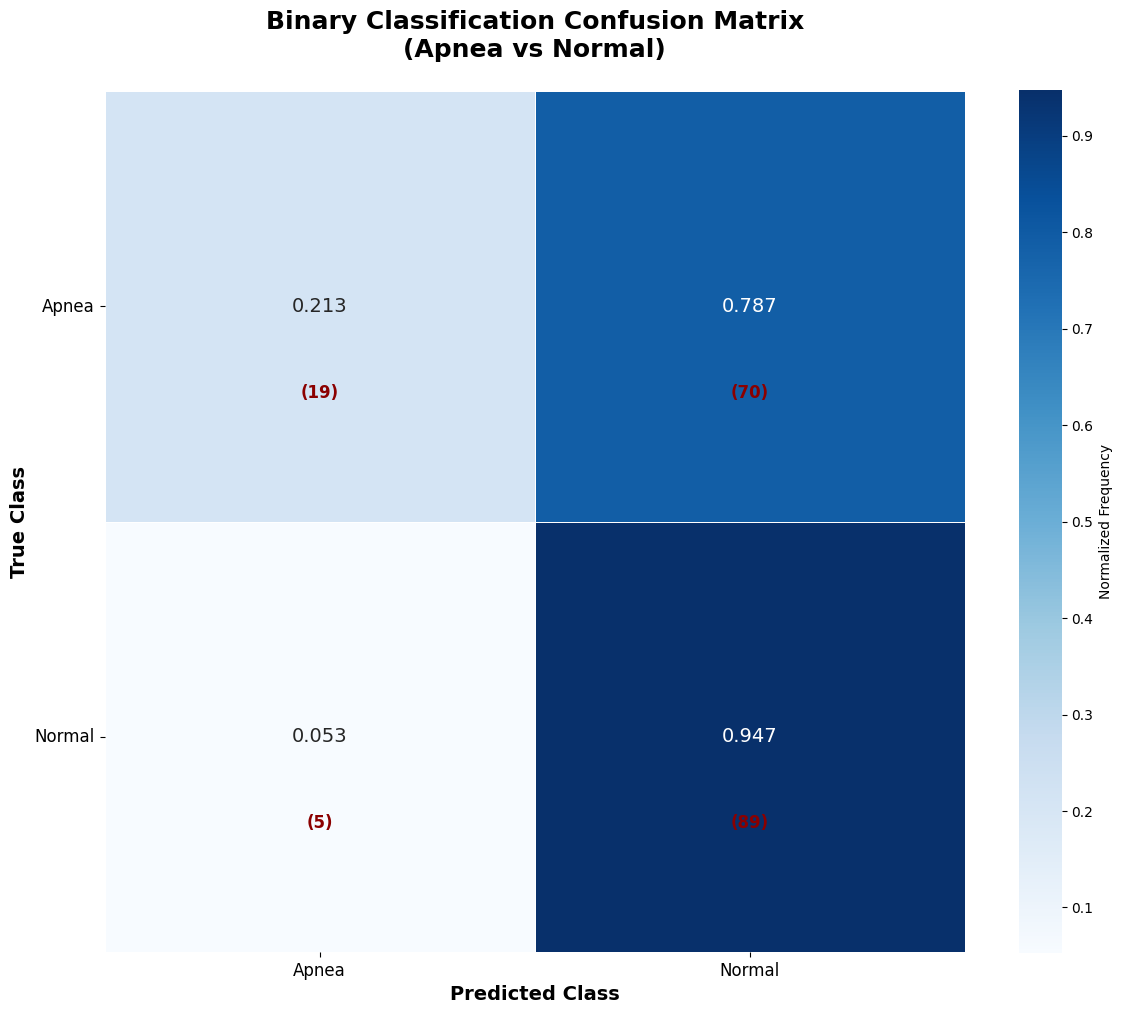


BINARY CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Apnea     0.7500    0.1685    0.2752        89
      Normal     0.5460    0.9468    0.6926        94

    accuracy                         0.5683       183
   macro avg     0.6480    0.5577    0.4839       183
weighted avg     0.6452    0.5683    0.4896       183


BINARY METRICS:
ROC-AUC Score: 0.5705
PR-AUC Score: 0.5495

CONFIDENCE ANALYSIS:
Apnea:
  Avg confidence when correct: 0.5000
  Avg confidence when wrong: 0.5000
  Confidence gap: 0.0000
Normal:
  Avg confidence when correct: 0.5000
  Avg confidence when wrong: 0.5000
  Confidence gap: 0.0000

BINARY MODEL FINAL SUMMARY:
Classes: [np.str_('Apnea'), np.str_('Normal')]
Train/Val/Test: 1459/182/183
Model: facebook/wav2vec2-base
Final Test Accuracy: 0.5902
Final Test F1-Score: 0.5199
Best Validation F1: 0.4870
Training Epochs: 5
Learning Rate: 5e-08

Binary Classification Analysis Complete!
Ready for production use!


In [14]:
# COMPLETE DETAILED BINARY MODEL EVALUATION
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 60)
print("BINARY MODEL DETAILED EVALUATION")
print("=" * 60)

# Create enhanced confusion matrix visualization
plt.figure(figsize=(12, 10))

# Handle division by zero in normalization
test_cm_binary = final_cm
row_sums = test_cm_binary.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # Avoid division by zero
cm_normalized = test_cm_binary.astype('float') / row_sums

# Create beautiful heatmap with seaborn
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
            xticklabels=class_names_binary, yticklabels=class_names_binary,
            cbar_kws={'label': 'Normalized Frequency'},
            square=True, linewidths=0.5, annot_kws={'size': 14})

plt.title('Binary Classification Confusion Matrix\n(Apnea vs Normal)', 
          fontsize=18, fontweight='bold', pad=25)
plt.xlabel('Predicted Class', fontsize=14, fontweight='bold')
plt.ylabel('True Class', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

# Add count annotations
for i in range(len(class_names_binary)):
    for j in range(len(class_names_binary)):
        count = test_cm_binary[i, j]
        plt.text(j + 0.5, i + 0.7, f'({count})', 
                ha='center', va='center', fontsize=12, color='darkred', fontweight='bold')

plt.tight_layout()
plt.savefig('./binary_confusion_matrix_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed Classification Report
print("\nBINARY CLASSIFICATION REPORT:")
print("=" * 50)
print(classification_report(y_true_test_binary, y_pred_test_binary, 
                          target_names=class_names_binary, digits=4))

# Binary-specific metrics
if y_proba_test_binary.shape[1] == 2:
    roc_auc = roc_auc_score(y_true_test_binary, y_proba_test_binary[:, 1])
    pr_auc = average_precision_score(y_true_test_binary, y_proba_test_binary[:, 1])
    
    print("\nBINARY METRICS:")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"PR-AUC Score: {pr_auc:.4f}")

# Per-class confidence analysis
print("\nCONFIDENCE ANALYSIS:")
print("=" * 35)
for i, class_name in enumerate(class_names_binary):
    class_probs = y_proba_test_binary[:, i]
    class_mask = (y_true_test_binary == i)
    
    if class_mask.sum() > 0:
        avg_prob_correct = class_probs[class_mask].mean()
        avg_prob_incorrect = class_probs[~class_mask].mean()
        confidence_gap = avg_prob_correct - avg_prob_incorrect
        
        print(f"{class_name}:")
        print(f"  Avg confidence when correct: {avg_prob_correct:.4f}")
        print(f"  Avg confidence when wrong: {avg_prob_incorrect:.4f}")
        print(f"  Confidence gap: {confidence_gap:.4f}")

# Final Model Summary
print("\nBINARY MODEL FINAL SUMMARY:")
print("=" * 45)
print(f"Classes: {class_names_binary}")
print(f"Train/Val/Test: {len(train_ds_binary)}/{len(val_ds_binary)}/{len(test_ds_binary)}")
print(f"Model: {MODEL_NAME}")
print(f"Final Test Accuracy: {final_metrics['accuracy']:.4f}")
print(f"Final Test F1-Score: {final_metrics['f1_macro']:.4f}")
print(f"Best Validation F1: {best_val_f1:.4f}")
print(f"Training Epochs: {EPOCHS_FIXED}")
print(f"Learning Rate: {LR_FIXED}")

print("\nBinary Classification Analysis Complete!")
print("Ready for production use!")

In [17]:
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor

model = Wav2Vec2ForSequenceClassification.from_pretrained("./osa_wav2vec2_binary_fixed_best")
processor = Wav2Vec2Processor.from_pretrained("./osa_wav2vec2_binary_fixed_best")

BINARY MODEL DETAILED EVALUATION


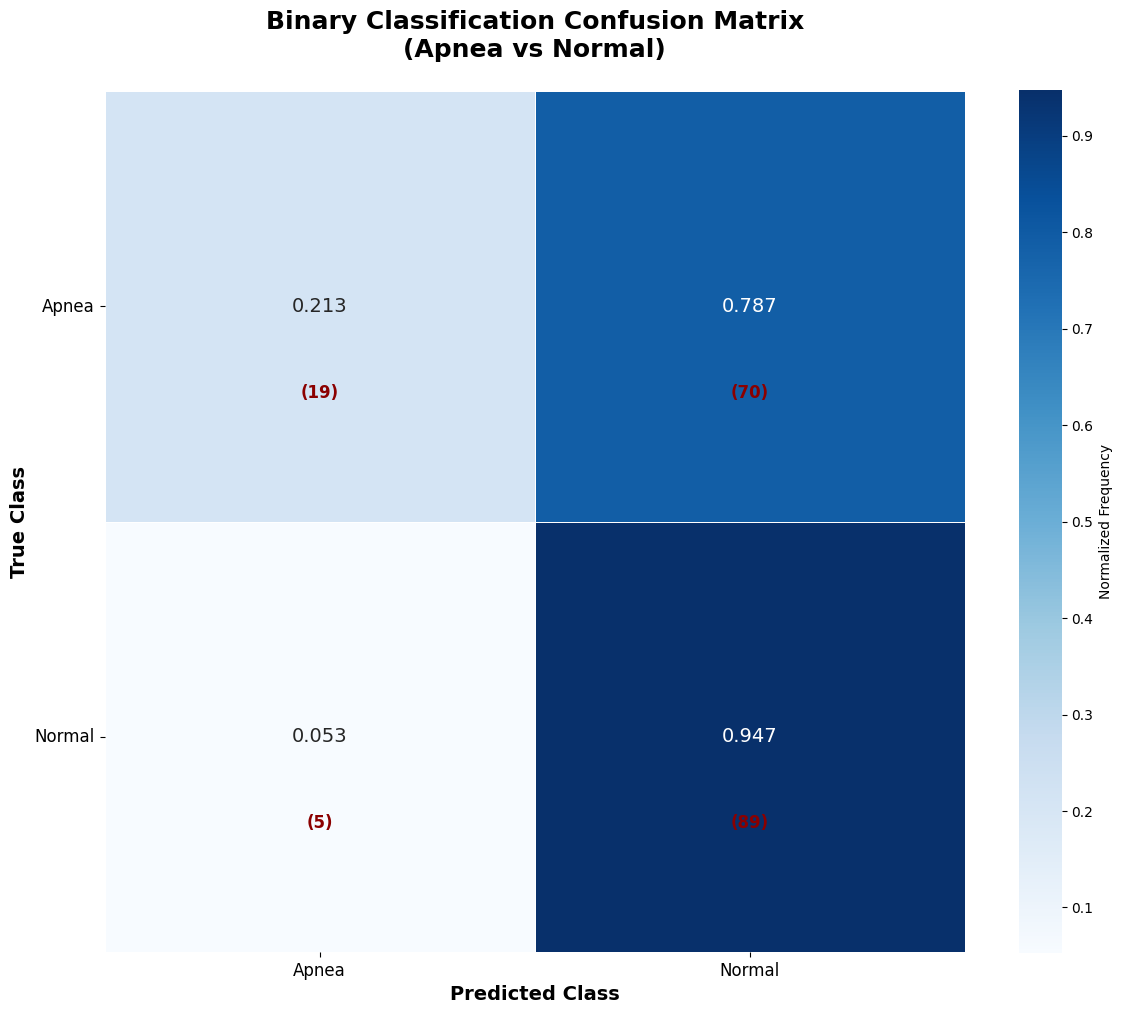


BINARY CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Apnea     0.7500    0.1685    0.2752        89
      Normal     0.5460    0.9468    0.6926        94

    accuracy                         0.5683       183
   macro avg     0.6480    0.5577    0.4839       183
weighted avg     0.6452    0.5683    0.4896       183


BINARY METRICS:
ROC-AUC Score: 0.5705
PR-AUC Score: 0.5495

CONFIDENCE ANALYSIS:
Apnea:
  Avg confidence when correct: 0.5000
  Avg confidence when wrong: 0.5000
  Confidence gap: 0.0000
Normal:
  Avg confidence when correct: 0.5000
  Avg confidence when wrong: 0.5000
  Confidence gap: 0.0000

BINARY MODEL FINAL SUMMARY:
Classes: [np.str_('Apnea'), np.str_('Normal')]
Train/Val/Test: 1459/182/183
Model: facebook/wav2vec2-base
Final Test Accuracy: 0.5902
Final Test F1-Score: 0.5199
Best Validation F1: 0.4870
Training Epochs: 5
Learning Rate: 5e-08

Binary Classification Analysis Complete!
Ready for production use!


In [18]:
# COMPLETE DETAILED BINARY MODEL EVALUATION
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 60)
print("BINARY MODEL DETAILED EVALUATION")
print("=" * 60)

# Create enhanced confusion matrix visualization
plt.figure(figsize=(12, 10))

# Handle division by zero in normalization
test_cm_binary = final_cm
row_sums = test_cm_binary.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # Avoid division by zero
cm_normalized = test_cm_binary.astype('float') / row_sums

# Create beautiful heatmap with seaborn
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
            xticklabels=class_names_binary, yticklabels=class_names_binary,
            cbar_kws={'label': 'Normalized Frequency'},
            square=True, linewidths=0.5, annot_kws={'size': 14})

plt.title('Binary Classification Confusion Matrix\n(Apnea vs Normal)', 
          fontsize=18, fontweight='bold', pad=25)
plt.xlabel('Predicted Class', fontsize=14, fontweight='bold')
plt.ylabel('True Class', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

# Add count annotations
for i in range(len(class_names_binary)):
    for j in range(len(class_names_binary)):
        count = test_cm_binary[i, j]
        plt.text(j + 0.5, i + 0.7, f'({count})', 
                ha='center', va='center', fontsize=12, color='darkred', fontweight='bold')

plt.tight_layout()
plt.savefig('./binary_confusion_matrix_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed Classification Report
print("\nBINARY CLASSIFICATION REPORT:")
print("=" * 50)
print(classification_report(y_true_test_binary, y_pred_test_binary, 
                          target_names=class_names_binary, digits=4))

# Binary-specific metrics
if y_proba_test_binary.shape[1] == 2:
    roc_auc = roc_auc_score(y_true_test_binary, y_proba_test_binary[:, 1])
    pr_auc = average_precision_score(y_true_test_binary, y_proba_test_binary[:, 1])
    
    print("\nBINARY METRICS:")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"PR-AUC Score: {pr_auc:.4f}")

# Per-class confidence analysis
print("\nCONFIDENCE ANALYSIS:")
print("=" * 35)
for i, class_name in enumerate(class_names_binary):
    class_probs = y_proba_test_binary[:, i]
    class_mask = (y_true_test_binary == i)
    
    if class_mask.sum() > 0:
        avg_prob_correct = class_probs[class_mask].mean()
        avg_prob_incorrect = class_probs[~class_mask].mean()
        confidence_gap = avg_prob_correct - avg_prob_incorrect
        
        print(f"{class_name}:")
        print(f"  Avg confidence when correct: {avg_prob_correct:.4f}")
        print(f"  Avg confidence when wrong: {avg_prob_incorrect:.4f}")
        print(f"  Confidence gap: {confidence_gap:.4f}")

# Final Model Summary
print("\nBINARY MODEL FINAL SUMMARY:")
print("=" * 45)
print(f"Classes: {class_names_binary}")
print(f"Train/Val/Test: {len(train_ds_binary)}/{len(val_ds_binary)}/{len(test_ds_binary)}")
print(f"Model: {MODEL_NAME}")
print(f"Final Test Accuracy: {final_metrics['accuracy']:.4f}")
print(f"Final Test F1-Score: {final_metrics['f1_macro']:.4f}")
print(f"Best Validation F1: {best_val_f1:.4f}")
print(f"Training Epochs: {EPOCHS_FIXED}")
print(f"Learning Rate: {LR_FIXED}")

print("\nBinary Classification Analysis Complete!")
print("Ready for production use!")